<a href="https://colab.research.google.com/github/LMAPcoder/Distributed-Data-Analytics-Lab/blob/main/DDA_sheet11_2_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab Distributed Data Analytics**

Leonardo Antiqui

N° 312940

Group 1

## Tutorial 11.2

1 Multi Worker Training

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.tensorboard import SummaryWriter
import torch.multiprocessing as mp

import time
import datetime
import copy

In [ ]:
torch.manual_seed(0)

2 Training with dataset partitions

Data

SVM files, also known as SVMlight files or LIBSVM files, are a data format commonly used for representing sparse datasets that are used in machine learning tasks, particularly in the context of Support Vector Machines (SVMs) and other algorithms that can handle sparse input data efficiently.

In [ ]:
#-From Google Drive
!wget --no-check-certificate -q 'https://docs.google.com/uc?export=download&id=1CnLE9PkUxJJ7AdZ-nsKcH554WKMymI3o' -O data.zip

In [ ]:
#unziping the file
!unzip data.zip
!rm data.zip #to remove the zip file

Archive:  data.zip
  inflating: a9a.svm                 
  inflating: gisette_scale.csv       


a9a

The goal of the Adult dataset is to predict based on census features of an individual American adult whether that person's income exceeds $50k/yr.

There are 123 total features in this dataset. The dataset is presented in this file in a sparse manner: features that are not present have value 0 implicitly.

In [ ]:
# Specify the file paths for the training and test datasets
train_file = "a9a.svm"

# Function to load SVMlight format data into a Pandas DataFrame
def load_svm_to_dataframe(file_path):
    data = []
    target = []
    with open(file_path, "r") as f:
        for line in f:
            tokens = line.strip().split() #by default any whitespace is a separator
            target_value = int(tokens[0])
            target.append(target_value)
            feature_dict = {}
            for token in tokens[1:]:
                feature_index, feature_value = token.split(":")
                feature_dict[int(feature_index)] = int(feature_value)
            data.append(feature_dict)
    return pd.DataFrame(data), np.array(target)

# Load training and test data
train_data, train_target = load_svm_to_dataframe(train_file)

# # Convert sparse feature columns to dense format
train_data = pd.DataFrame.from_records(train_data).fillna(0)

In [ ]:
train_data.tail()

,3,11,14,19,39,42,55,64,67,73,...,120,92,12,115,102,122,105,13,113,123
32556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32557,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32558,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32559,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Targets
unique, counts = np.unique(train_target, return_counts=True)
print('Classes:',dict(zip(unique, counts)))

Classes: {-1: 24720, 1: 7841}


The classes are 1 and -1 because a9a is a dataset used to train SVMs. To train a NN with sigmoid function we need the negative class to be zero.

In [ ]:
#Converting negative classes in 0
train_target = np.maximum(0,train_target)

In [ ]:
X = torch.tensor(train_data.values, dtype=torch.float32)
Y = torch.tensor(train_target, dtype=torch.float32).view(-1, 1)

data = torch.utils.data.TensorDataset(X, Y)

batch = 20

train_ds, test_ds = torch.utils.data.random_split(data, [0.8, 0.2])
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch, shuffle=False)

Training

In [ ]:
# Utility function to train the model
def fit(num_epochs, model, loss_fn, opt, train_dl, test_dl, queue=None, device='cpu'):

    loss_curve = list()
    start_time = time.time() #starting time of the training algorithm

    process_name = mp.current_process().name

    #each process should have its own SummaryWriter instance
    log_dir = "logs/" + process_name + '-' + datetime.datetime.now().strftime("%m.%d-%H:%M:%S")
    writer = SummaryWriter(log_dir)

    example_data, example_targets = next(iter(train_dl))
    example_data = example_data.to(device)

    writer.add_graph(model, example_data)

    # Repeat for given number of epochs
    for epoch in range(num_epochs):
        start_time_epoch = time.time() #starting time of the epoch

        model.train() #setup model for training. Some types of layers, like batch normalization or dropout, behave differently

        L = 0
        i = 0

        # Train with batches of data
        for xb, yb in train_dl:

            xb = xb.to(device)
            yb = yb.to(device)

            # 1. Generate predictions
            Y_hat = model(xb)

            # 2. Calculate loss
            loss = loss_fn(Y_hat, yb)

            # 3. Compute gradients
            loss.backward()

            # 4. Update parameters using gradients
            opt.step()

            # 5. Reset the gradients to zero
            opt.zero_grad()

            #Save loss function values
            i += 1
            L += (1/i)*(loss.detach().item()-L)

        loss_curve.append(L)

        #Computing accuracy on train and test datasets
        train_acc = accuracy(model, train_dl, device)
        test_acc = accuracy(model, test_dl, device)

        end_time_epoch = time.time() #end time of the epoch
        elapsed_time = end_time_epoch - start_time_epoch

        if epoch%2 == 0:
            print(f'Rank {process_name}, epoch: {epoch}, time_epoch: {elapsed_time:.2f}, '
            f'training_loss: {L:.2f}, training_accuracy: {train_acc:.2f}, test_accuracy: {test_acc:.2f}')

        #Traking scalars
        writer.add_scalar(tag='training_loss', scalar_value=loss.detach(), global_step=epoch)
        writer.add_scalar(tag='training_accuracy', scalar_value=train_acc, global_step=epoch)
        writer.add_scalar(tag='test_accuracy', scalar_value=test_acc, global_step=epoch)

        #The SummaryWriter automatically flushes the events to disk at regular intervals.
        writer.flush()

    writer.close() # Close the SummaryWriter

    #Retrieving loss data
    if queue is not None:
      queue.put(loss_curve)
    else:
      return loss_curve

def accuracy(model, data_loader, device='cpu'):

    correct_pred = 0
    n = 0

    model.eval() #setup model for evaluation

    with torch.no_grad():

        for X, y in data_loader:

            X = X.to(device)
            y = y.to(device)

            y_logits = model(X)
            y_hat = torch.round(y_logits) #valid for binary classification problems
            #(y_logits >= threshold).int() to use a threshold

            n += y.size(0)
            correct_pred += (y_hat == y).sum().item()

    return correct_pred / n

In [ ]:

model = torch.nn.Sequential(

    torch.nn.Linear(in_features=123, out_features=82),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(in_features=82, out_features=55),
    torch.nn.ReLU(inplace=True),
    # torch.nn.BatchNorm1d(32),
    torch.nn.Linear(in_features=55, out_features=1),
    torch.nn.Sigmoid()
  )

state_dict = model.state_dict() #to save the original state of the model
state_dict_original = copy.deepcopy(state_dict)


num_epochs = 10 #maximum number of ephocs
lr = 0.1 #learning rate

#Stochastic Gradient Descent
opt = torch.optim.SGD(
    model.parameters(),
    lr=lr, #learning rate
    momentum=0.5, #momentum factor
    weight_decay=0.001 #weight decay (L2 penalty)
    )

#Adam
# opt = torch.optim.Adam(
#     model.parameters(),
#     lr=lr, #learning rate
#     weight_decay=0.001 #weight decay (L2 penalty)
#     )

#Loss function
loss = torch.nn.BCELoss() # Binary Cross Entropy Loss between the target and the input probabilities

In [ ]:
from torchsummary import summary
summary(model,X.size())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 32561, 82]          10,168
              ReLU-2            [-1, 32561, 82]               0
            Linear-3            [-1, 32561, 55]           4,565
              ReLU-4            [-1, 32561, 55]               0
            Linear-5             [-1, 32561, 1]              56
           Sigmoid-6             [-1, 32561, 1]               0
Total params: 14,789
Trainable params: 14,789
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 15.28
Forward/backward pass size (MB): 68.56
Params size (MB): 0.06
Estimated Total Size (MB): 83.90
----------------------------------------------------------------


Single worker

In [ ]:
%%time
loss_curve_single = fit(num_epochs, model, loss, opt, train_loader, test_loader)

Rank MainProcess, epoch: 0, time_epoch: 1.78, training_loss: 0.39, training_accuracy: 0.84, test_accuracy: 0.83
Rank MainProcess, epoch: 2, time_epoch: 0.96, training_loss: 0.33, training_accuracy: 0.85, test_accuracy: 0.84
Rank MainProcess, epoch: 4, time_epoch: 0.98, training_loss: 0.33, training_accuracy: 0.85, test_accuracy: 0.85
Rank MainProcess, epoch: 6, time_epoch: 0.97, training_loss: 0.32, training_accuracy: 0.85, test_accuracy: 0.84
Rank MainProcess, epoch: 8, time_epoch: 0.96, training_loss: 0.32, training_accuracy: 0.85, test_accuracy: 0.84
CPU times: user 10.2 s, sys: 31.7 ms, total: 10.2 s
Wall time: 10.7 s


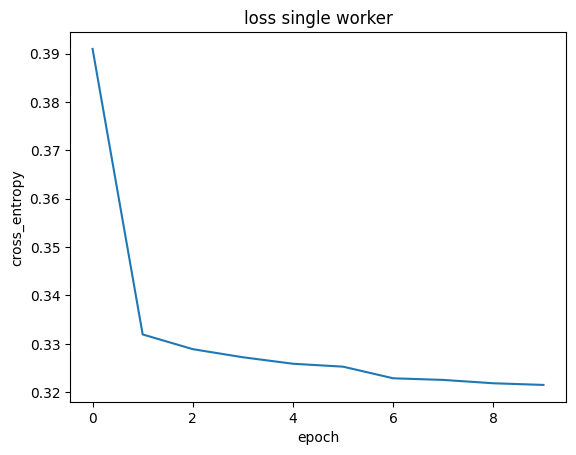

In [ ]:
plt.plot(loss_curve_single)
plt.xlabel('epoch')
plt.ylabel('cross_entropy')
plt.title('loss single worker')
plt.show()

Multiple workers

In [ ]:
#model.share_memory() method helps to allocate shared memory for the model parameters so that they can be accessed by multiple processes.
model.share_memory()

Sequential(
  (0): Linear(in_features=123, out_features=82, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=82, out_features=55, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=55, out_features=1, bias=True)
  (5): Sigmoid()
)

In [ ]:
%%time

num_processes = 2
num_epochs = 10 #maximum number of ephocs
batch = 20

data = np.hstack((train_target.reshape(-1,1),train_data.values))
partitions = np.array_split(np.random.permutation(data), num_processes, axis=0) #spliting the dataset


model.load_state_dict(state_dict_original)

# Create a list of processes and start each process with the fit function
processes = []

queue = mp.Queue()

for rank in range(num_processes):

  partition = partitions[rank]

  X = torch.tensor(partition[:,1:], dtype=torch.float32)
  Y = torch.tensor(partition[:,0], dtype=torch.float32).view(-1, 1)

  data = torch.utils.data.TensorDataset(X, Y)

  train_ds, test_ds = torch.utils.data.random_split(data, [0.8, 0.2])
  train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch, shuffle=False)

  p = mp.Process(target=fit, args =(num_epochs, model, loss, opt, train_loader, test_loader, queue), name=f'Process-{rank}')

  p.start() #starts the process

  processes.append(p)

  print(f'Started {p.name}')

# Wait for all processes to finish
for p in processes:
  p.join()
  print(f'Finished {p.name}')

loss_curves = list()
for _ in range(num_processes):
  loss_curve = queue.get(timeout=30)
  loss_curves.append(loss_curve)

Started Process-0
Started Process-1
Rank Process-0, epoch: 0, time_epoch: 2.42, training_loss: 0.36, training_accuracy: 0.81, test_accuracy: 0.80
Rank Process-1, epoch: 0, time_epoch: 2.82, training_loss: 0.37, training_accuracy: 0.84, test_accuracy: 0.85
Rank Process-0, epoch: 2, time_epoch: 2.83, training_loss: 0.33, training_accuracy: 0.84, test_accuracy: 0.85
Rank Process-1, epoch: 2, time_epoch: 2.85, training_loss: 0.34, training_accuracy: 0.85, test_accuracy: 0.86
Rank Process-0, epoch: 4, time_epoch: 1.65, training_loss: 0.33, training_accuracy: 0.85, test_accuracy: 0.84
Rank Process-1, epoch: 4, time_epoch: 1.67, training_loss: 0.33, training_accuracy: 0.84, test_accuracy: 0.85
Rank Process-0, epoch: 6, time_epoch: 2.04, training_loss: 0.32, training_accuracy: 0.85, test_accuracy: 0.85
Rank Process-1, epoch: 6, time_epoch: 2.29, training_loss: 0.33, training_accuracy: 0.85, test_accuracy: 0.86
Rank Process-0, epoch: 8, time_epoch: 1.63, training_loss: 0.32, training_accuracy: 

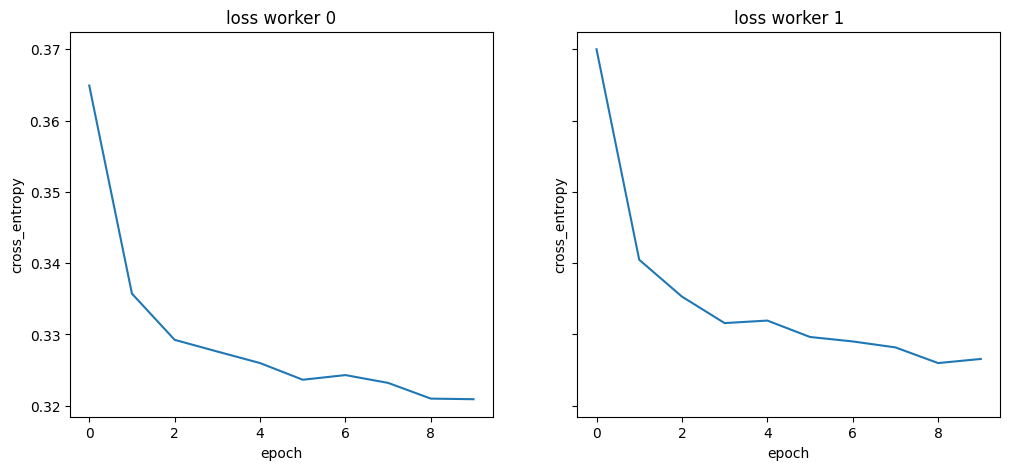

In [ ]:
loss_curve_0, loss_curve_1 = loss_curves

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(12,5), sharey=True)

ax1.plot(loss_curve_0)

ax2.plot(loss_curve_1)

ax1.set_title('loss worker 0')
ax1.set_xlabel('epoch')
ax1.set_ylabel('cross_entropy')

ax2.set_title('loss worker 1')
ax2.set_xlabel('epoch')
ax2.set_ylabel('cross_entropy')

plt.show()

3 Network Architecture

4 Speeding up Fully-Connected Networks

In [ ]:
import pandas as pd
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset
import time
import copy

In [ ]:
torch.manual_seed(0)

GISETTE

GISETTE is a handwritten digit recognition problem. The problem is to separate the highly confusible digits '4' and '9'. This dataset is one of five datasets of the NIPS 2003 feature selection challenge.

The digits have been size-normalized and centered in a fixed-size image of dimension 28x28. The original data were modified for the purpose of the feature selection challenge. In particular, pixels were samples at random in the middle top part of the feature containing the information necessary to disambiguate 4 from 9 and higher order features were created as products of these pixels to plunge the problem in a higher dimensional feature space.

The dataset includes a total of 5000 features, 2500 of them with no predictive power. The order of the features and patterns were randomized.

In [ ]:
dataset = pd.read_csv("gisette_scale.csv", index_col=0, header=0)

In [ ]:
x = dataset.values[:, 1:]
y = dataset.values[:, 0]
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

In [ ]:
model = nn.Sequential(
    nn.Linear(5000, 512), nn.ReLU(),
    nn.Linear(512, 512),  nn.ReLU(),
    nn.Linear(512, 512),  nn.ReLU(),
    nn.Linear(512, 512),  nn.ReLU(),
    nn.Linear(512, 512),  nn.ReLU(),
    nn.Linear(512, 512),  nn.ReLU(),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

state_dict = model.state_dict() #to save the original state of the model
state_dict_original = copy.deepcopy(state_dict)

opt = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss() # Binary Cross Entropy Loss

epochs = 5

In [ ]:
from torchsummary import summary
summary(model,x.size())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 6000, 512]       2,560,512
              ReLU-2            [-1, 6000, 512]               0
            Linear-3            [-1, 6000, 512]         262,656
              ReLU-4            [-1, 6000, 512]               0
            Linear-5            [-1, 6000, 512]         262,656
              ReLU-6            [-1, 6000, 512]               0
            Linear-7            [-1, 6000, 512]         262,656
              ReLU-8            [-1, 6000, 512]               0
            Linear-9            [-1, 6000, 512]         262,656
             ReLU-10            [-1, 6000, 512]               0
           Linear-11            [-1, 6000, 512]         262,656
             ReLU-12            [-1, 6000, 512]               0
           Linear-13              [-1, 6000, 1]             513
          Sigmoid-14              [-1, 

In [ ]:
def fit(loader, model, opt, loss_fn, epochs):

  start_time = time.time() #starting time of the training algorithm

  for epoch in range(epochs):

      start_time_epoch = time.time() #starting time of the epoch

      epoch_acc = 0.0
      total_points = 0.0
      for x, y in loader:
          y = y.reshape(-1, 1)
          opt.zero_grad()
          y_hat = model(x)
          loss_val = loss_fn(y_hat, y)
          loss_val.backward()
          opt.step()
          total_points += len(y)
          epoch_acc += len(y) - ((y_hat > 0.5).int() - (y > 0.5).int()).abs().sum().item()

      end_time_epoch = time.time() #end time of the epoch
      elapsed_time = end_time_epoch - start_time_epoch

      print(f"epoch {epoch} ACC: {epoch_acc/total_points:.2f} time_epoch: {elapsed_time:.2f}")

  end_time = time.time() #end time of the training algorithm
  elapsed_time = end_time - start_time

  print(f'Total time: {elapsed_time}')

In [ ]:
%%time
batch_sizes = [12,48,192,768]

for batch_size in batch_sizes:
  model.load_state_dict(state_dict_original)

  loader = DataLoader(TensorDataset(x, y), batch_size=batch_size, shuffle=True)
  print(f'Batch size: {batch_size}')

  fit(loader, model, opt, loss_fn, epochs)

Batch size: 12
epoch 0 ACC: 0.82 time_epoch: 18.01
epoch 1 ACC: 0.95 time_epoch: 39.80
epoch 2 ACC: 0.97 time_epoch: 43.77
epoch 3 ACC: 0.98 time_epoch: 42.46
epoch 4 ACC: 0.98 time_epoch: 43.59
Total time: 187.6292371749878
Batch size: 48
epoch 0 ACC: 0.82 time_epoch: 7.64
epoch 1 ACC: 0.96 time_epoch: 6.68
epoch 2 ACC: 0.97 time_epoch: 6.33
epoch 3 ACC: 0.98 time_epoch: 6.84
epoch 4 ACC: 0.98 time_epoch: 6.50
Total time: 33.97772836685181
Batch size: 192
epoch 0 ACC: 0.55 time_epoch: 3.12
epoch 1 ACC: 0.61 time_epoch: 3.92
epoch 2 ACC: 0.93 time_epoch: 3.16
epoch 3 ACC: 0.95 time_epoch: 3.21
epoch 4 ACC: 0.97 time_epoch: 3.57
Total time: 16.973634243011475
Batch size: 768
epoch 0 ACC: 0.57 time_epoch: 2.80
epoch 1 ACC: 0.50 time_epoch: 2.39
epoch 2 ACC: 0.50 time_epoch: 2.38
epoch 3 ACC: 0.68 time_epoch: 2.34
epoch 4 ACC: 0.76 time_epoch: 2.92
Total time: 12.832876205444336
CPU times: user 4min 7s, sys: 299 ms, total: 4min 7s
Wall time: 4min 11s


We can see that the larger the batch size the faster the training procedure

Speeding up dense layers

Dense layers per se can be speeded up using mixed precision Training. Mixed precision training  offers significant computational speedup by performing operations in half-precision format (FP16), while storing minimal information in single-precision to retain as much information as possible in critical parts of the network.

Speeding up network

Batch Normalization can improve training stability, speed up convergence, and potentially enhance generalization.

In [ ]:
model = nn.Sequential(
    nn.Linear(5000, 512), nn.BatchNorm1d(512), nn.ReLU(),
    nn.Linear(512, 512),  nn.ReLU(),
    nn.Linear(512, 512),  nn.ReLU(),
    nn.Linear(512, 512),  nn.ReLU(),
    nn.Linear(512, 512),  nn.ReLU(),
    nn.Linear(512, 512),  nn.ReLU(),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

opt = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss() # Binary Cross Entropy Loss

loader = DataLoader(TensorDataset(x, y), batch_size=768, shuffle=True)

In [ ]:
fit(loader, model, opt, loss_fn, epochs)

epoch 0 ACC: 0.87 time_epoch: 3.09
epoch 1 ACC: 0.98 time_epoch: 2.38
epoch 2 ACC: 0.99 time_epoch: 2.34
epoch 3 ACC: 1.00 time_epoch: 2.44
epoch 4 ACC: 1.00 time_epoch: 3.37
Total time: 13.620479345321655


We can see here that adding a batchnormalization layer right after the linear layer with the highest number of parameters speeded up the convergence of the training procedure. This way we can use a larger batch size to speed up the training procedure.

Flower dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.tensorboard import SummaryWriter
import torch.multiprocessing as mp
import torchvision
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset

import time
import datetime
import copy

In [ ]:
torch.manual_seed(0)

In [ ]:
#Downloading file
!wget --no-check-certificate -q 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz' -O flower_photos.tgz

In [ ]:
#untarring the file
!sudo tar -xzf flower_photos.tgz
!rm flower_photos.tgz #to remove the tar file

In [ ]:
#Transformation to apply while generating the data
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize (size =(180 , 180)),
    torchvision.transforms.ToTensor() ,])

#Getting data from folder
data = torchvision.datasets.ImageFolder(root="flower_photos", transform=train_transforms)

#We split the train dataset into a train and test dataset
train_ds, test_ds = torch.utils.data.random_split(data, [0.8, 0.2])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2) #parallelization of data loading
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

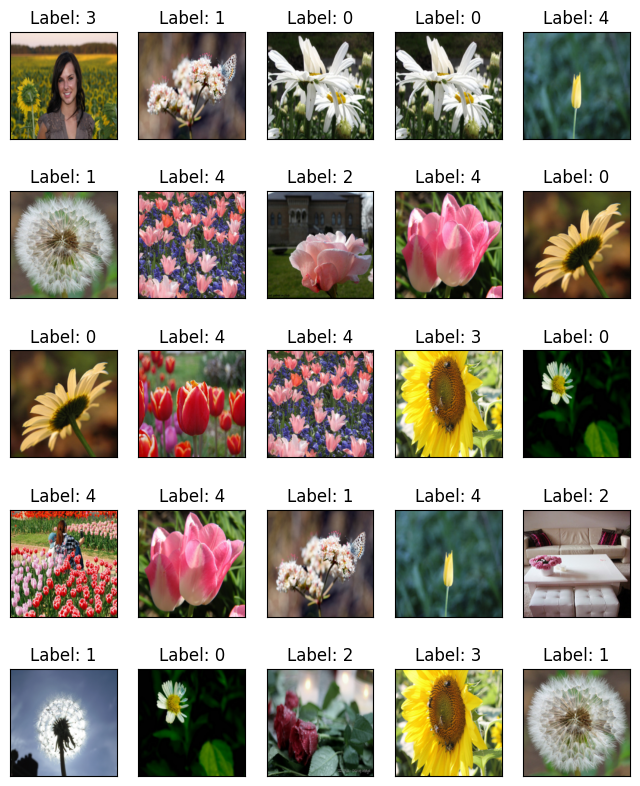

In [ ]:
#Printing a random subset of training dataset along with the labels
for images, labels in train_loader:
  fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(8,10))
  for i in range(5):
    for j in range(5):
      idx = np.random.randint(images.shape[0])
      ax[i,j].set_title(f'Label: {labels[idx]}')
      ax[i,j].imshow(images[idx].permute(1, 2, 0))
      ax[i,j].axes.yaxis.set_visible(False)
      ax[i,j].axes.xaxis.set_visible(False)
  break

In [ ]:
# Utility function to train the model
def accuracy(model, data_loader, device='cpu'):

    correct_pred = 0
    n = 0

    model.eval() #setup model for evaluation

    with torch.no_grad():

        for X, y in data_loader:

            X = X.to(device)
            y = y.to(device)

            y_logits = model(X)
            _, y_hat = torch.max(y_logits, dim=1) #valid for multiclass problem

            n += y.size(0)
            correct_pred += (y_hat == y).sum().item()

    return correct_pred / n

In [ ]:
#Check for availability of GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    name = torch.cuda.get_device_name(0)
    print(f'GPU {name} is available!')
else:
    device = torch.device('cpu')
    print('GPU is not available, using CPU instead.')

GPU is not available, using CPU instead.


In [ ]:
#Hyperparameters
num_classes = 5

model = torch.nn.Sequential(

    torch.nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=3, padding=0),
    torch.nn.ReLU(inplace=True),
    torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=3, padding=0),
    torch.nn.ReLU(inplace=True),
    torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=0),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=18*18*512, out_features=512),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(in_features=512, out_features=num_classes)
  ).to(device)

state_dict = model.state_dict() #to save the original state of the model
state_dict_original = copy.deepcopy(state_dict)

In [ ]:
summary(model,(3,180,180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 60]           3,584
              ReLU-2          [-1, 128, 60, 60]               0
            Conv2d-3          [-1, 256, 20, 20]         295,168
              ReLU-4          [-1, 256, 20, 20]               0
            Conv2d-5          [-1, 512, 18, 18]       1,180,160
           Flatten-6               [-1, 165888]               0
            Linear-7                  [-1, 512]      84,935,168
              ReLU-8                  [-1, 512]               0
            Linear-9                    [-1, 5]           2,565
Total params: 86,416,645
Trainable params: 86,416,645
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.37
Forward/backward pass size (MB): 11.13
Params size (MB): 329.65
Estimated Total Size (MB): 341.16
--------------------------------

In [ ]:
lr = 0.01 #learning rate

loss = torch.nn.CrossEntropyLoss() #cross entropy loss between input logits and target
opt = torch.optim.SGD(
    model.parameters(),
    lr=lr, #learning rate
    momentum=0.1 #momentum factor
    )

In [ ]:
%%time

num_epochs = 1

batch_sizes = [32,128,512]

for batch_size in batch_sizes:
  model.load_state_dict(state_dict_original)

  train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
  test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

  print(f'Batch size: {batch_size}')

  loss_curve_single = fit(num_epochs, model, loss, opt, train_loader, test_loader, device=device)

Batch size: 32
Rank MainProcess, epoch: 0, time_epoch: 270.75, training_loss: 1.55, training_accuracy: 0.44, test_accuracy: 0.43
Batch size: 128
Rank MainProcess, epoch: 0, time_epoch: 252.42, training_loss: 1.59, training_accuracy: 0.34, test_accuracy: 0.35
Batch size: 512
Rank MainProcess, epoch: 0, time_epoch: 236.78, training_loss: 1.61, training_accuracy: 0.24, test_accuracy: 0.26
CPU times: user 11min 34s, sys: 1min 37s, total: 13min 12s
Wall time: 13min 48s


We can see that larger batch sizes slightly decrease the time per epoch.

Prunning

Model pruning involves removing less important weights or neurons from a neural network to reduce its size and computational complexity.

In [ ]:
import torch.nn.utils.prune as prune

In [ ]:
for module in model.children():
  if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
    prune.l1_unstructured(module, name="weight", amount=0.5)  # Prune 50% of weights
    prune.remove(module, "weight")

In [ ]:
%%time
num_epochs = 3
model.load_state_dict(state_dict_original)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)


loss_curve_single = fit(num_epochs, model, loss, opt, train_loader, test_loader, device=device)


Rank MainProcess, epoch: 0, time_epoch: 336.40, training_loss: 1.01, training_accuracy: 0.62, test_accuracy: 0.54
Rank MainProcess, epoch: 2, time_epoch: 360.35, training_loss: 1.01, training_accuracy: 0.62, test_accuracy: 0.54


Model prunning did not speed up the training algorithm

Depth-wise Separable Convolutional Layer

Depth-wise separable convolutions are a type of convolutional operation that split the spatial and depth dimensions of convolutions, allowing for reduced computational complexity. Reduces computation by factor of d (input channel), which is significant in late layers.

In [ ]:
num_classes = 5

model = torch.nn.Sequential(

    torch.nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=3, padding=0),
    torch.nn.ReLU(inplace=True),

    #Depth-wise Separable Convolutional Layer
    torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=3, padding=0, groups=128),
    torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1),
    torch.nn.ReLU(inplace=True),

    #Depth-wise Separable Convolutional Layer
    torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0, groups=256),
    torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=18*18*512, out_features=512),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(in_features=512, out_features=num_classes)
  ).to(device)

summary(model,(3,180,180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 60]           3,584
              ReLU-2          [-1, 128, 60, 60]               0
            Conv2d-3          [-1, 128, 20, 20]           1,280
            Conv2d-4          [-1, 256, 20, 20]          33,024
              ReLU-5          [-1, 256, 20, 20]               0
            Conv2d-6          [-1, 256, 18, 18]           2,560
            Conv2d-7          [-1, 512, 18, 18]         131,584
           Flatten-8               [-1, 165888]               0
            Linear-9                  [-1, 512]      84,935,168
             ReLU-10                  [-1, 512]               0
           Linear-11                    [-1, 5]           2,565
Total params: 85,109,765
Trainable params: 85,109,765
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.37
Fo

In [ ]:
%%time
num_epochs = 3
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

loss_curve_single = fit(num_epochs, model, loss, opt, train_loader, test_loader, device=device)

Rank MainProcess, epoch: 0, time_epoch: 111.52, training_loss: 1.61, training_accuracy: 0.17, test_accuracy: 0.18
Rank MainProcess, epoch: 2, time_epoch: 117.16, training_loss: 1.61, training_accuracy: 0.17, test_accuracy: 0.18
CPU times: user 4min 1s, sys: 1min 25s, total: 5min 27s
Wall time: 5min 48s


We can see that the incorporation of depth-wise Separable Convolutional Layer speeds up the learning procedure 3 times, but affect the model performance negatively